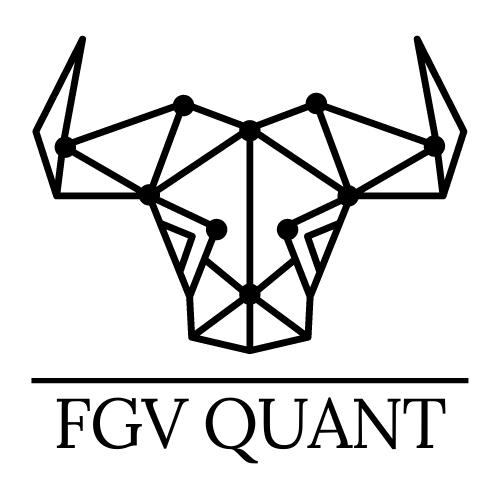

# 1.0 Import Libraries

Import some important libraries to calculate parameters, I love to use Sympy library to set Black & Scholes 

In [1]:
import numpy as np
from sympy import *
import sympy as sp
import yfinance as yf
import matplotlib.pyplot as plt
import math

# 2.0 Download Data

Download data from 3 years to get the historical volatility, I have choosen the SP500 index to calculate the parameters in this notebook

In [2]:
df=yf.download("^GSPC",start="2019-01-01",end="2022-01-01",progress=False)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,2476.959961,2519.489990,2467.469971,2510.030029,2510.030029,3733160000
2019-01-03,2491.919922,2493.139893,2443.959961,2447.889893,2447.889893,3822860000
2019-01-04,2474.330078,2538.070068,2474.330078,2531.939941,2531.939941,4213410000
2019-01-07,2535.610107,2566.159912,2524.560059,2549.689941,2549.689941,4104710000
2019-01-08,2568.110107,2579.820068,2547.560059,2574.409912,2574.409912,4083030000
...,...,...,...,...,...,...
2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,4791.189941,2264120000
2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,4786.350098,2217050000
2021-12-29,4788.640137,4804.060059,4778.080078,4793.060059,4793.060059,2369370000


# 3.0 Calculating Historical Volatility

Using a simple method to calculate Historical Volatity

reference: **Advanced Topics in Derivatives Pricing - Columbia University Course**

In [3]:
df["Returns"]=df["Adj Close"].pct_change()
df["Log_Returns"]=np.log(1+df["Returns"])
std_log_returns=df["Log_Returns"].std()
annual_volatility=np.sqrt(252)*std_log_returns
print(f"Volatility: {annual_volatility*100:.2f}%")

Volatility: 22.60%


# 4.0 Set Black & Scholes Model

The Black & Scholes Option Pricing Model (BSOPM) is the most used equation to find vanilla european options prices and it´s very popular in the market, at the cells below we are going to define the parameters used in BSOPM and set the model

In [51]:
x, y ,z, S, q, T, r,K,v =sp.symbols("x y z S q T r K v ")
(x,y,z,S,q,T,r,K,v)

(x, y, z, S, q, T, r, K, v)

In [52]:
def CDF(value):
    CDF = integrate((1/sqrt(2*pi*1))*exp(-1*((x-0)**2)/(2*1**2)),(x,-oo,value))
    return(N(CDF))
d1=(ln(S/K)+(r-q+0.5*v**2)*T)/(v*sqrt(T))
d2=d1-v*sqrt(T)
black_scholes= S*exp(-q*T)*CDF(d1)-exp(-r*T)*K*CDF(d2) # Call Option
black_scholes


-K*(0.5*erf(sqrt(2)*(-sqrt(T)*v + (T*(-q + r + 0.5*v**2) + log(S/K))/(sqrt(T)*v))/2) + 0.5)*exp(-T*r) + S*(0.5*erf(sqrt(2)*(T*(-q + r + 0.5*v**2) + log(S/K))/(2*sqrt(T)*v)) + 0.5)*exp(-T*q)

# 5.0 Concepts of Binomial Tree Option Pricing Model

The **Binomial Tree Option Pricing Model** is very used to precify different types of derivatives.

Option pricing model for american option style, assuming stocks who follows an **Geometric Brownian Motion** and the **risk free neutrality** assumption is True, so the fair price is the **expected mathematical future value** in the present by the **risk free discount rate**

An example of a Binomial Tree is:


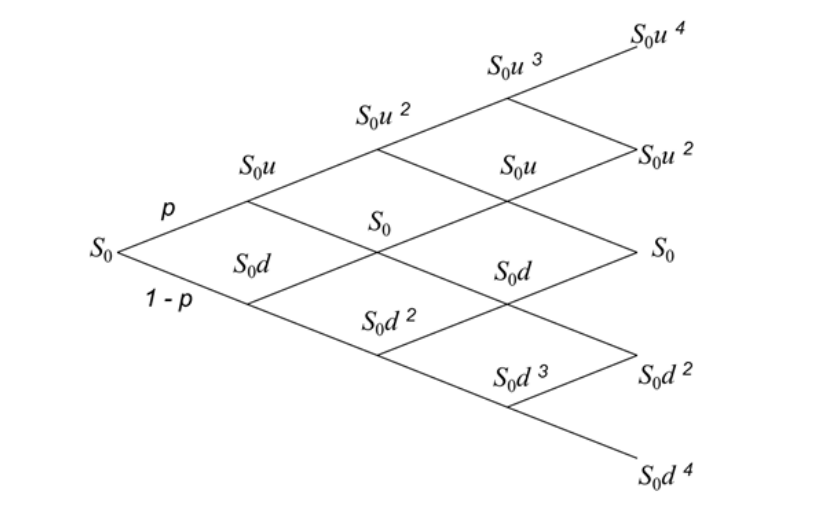

One of the principles in the BTOPM is that one Down Move followed by an Up move need to stay at the same initial price, the same occours for an Up move followed by an Down move

# 6.0 Set Jarrow Rudd Model

The **Jarrow Rudd Binomial Tree Option Pricing Model** is also named as the **equal probability model**, because it assumes 50% probability of go up and 50% of probability to go down

The **Up** factor in Jarrow Rudd follows the below equation

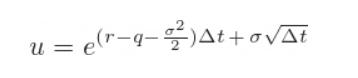

The **Down** move follows the next equation:

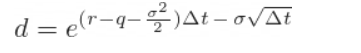

In [14]:
def JRR(Spot,Strike,Volatility,Time,RiskFree,Steps,Tipo):
    dt = Time/Steps
    u=np.exp((RiskFree-Volatility**2/2)*dt + Volatility*np.sqrt(dt))
    d=np.exp((RiskFree-Volatility**2/2)*dt - Volatility*np.sqrt(dt))
    path=np.zeros(Steps+1)
    for a in range(Steps+1):
        path[a]=Spot*u**a*d**(Steps-a)
        
    path2=np.zeros(Steps+1)
    for b in range(Steps+1):
        if Tipo=="C":
            path2[b]=max(path[b]-Strike,0)
        if Tipo=="P":
            path2[b]=max(Strike-path[b],0)
    #-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    # going back into the three
    discount = np.exp(-RiskFree*dt)
    for i in np.arange(Steps-1,-1,-1):
        for k in range(0,i+1):
             path2[k]=discount*(0.5*path2[k+1]+0.5*path2[k])
    return path2[0]

# 7.0 Cox Ross Rubinstein 

We need to build the final column of the tree to go back and find the price at the instant zero

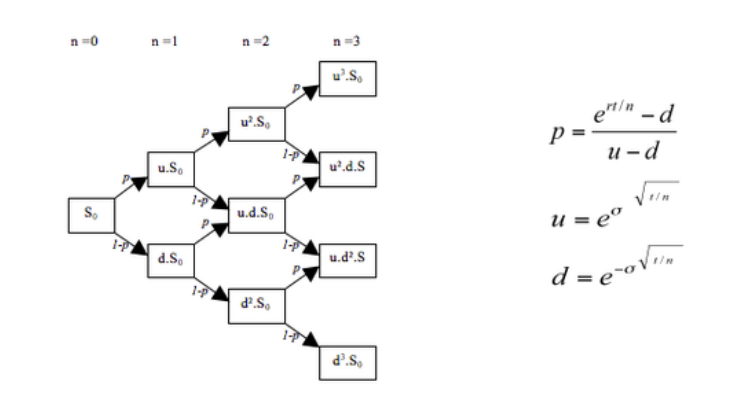

The Cox Ross Rubinstein assumes that the tree is recombinant, if the underlying  asset moves up and moves down the price will be the same as if it had moved down and up. The up factor and down factor can be achieved by

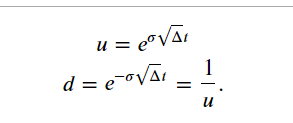

We dont need to build all the tree we just need to find the values in the last column, so there is a general formula to determine the stock value in each node that I want

$${\displaystyle S_{n}=S_{0}\times u^{N_{u}-N_{d}},}$$

So the option price in each node can be achieved by: 

$$
{\displaystyle C_{t-\Delta t,i}=e^{-r\Delta t}(pC_{t,i}+(1-p)C_{t,i+1})\,}
$$

In [15]:
def CRR(Spot,Strike,Volatility,Years_to_Expiration,Risk_Free,steps,tipo):
    # parameters:
    dt=Years_to_Expiration/steps # time passes by each node
    u=math.exp(Volatility*math.sqrt(dt)) # up factor by each node
    d=1/u  # down factor by each node
    #-=-=-=-=--=-=-=-=-=-=-=-=
    # Going into the three
    path=np.zeros(steps+1) # creating my final column of values
    for i in range(steps+1):
        path[i]=Spot*u**i*d**(steps-i) # general formula to find the price of each node in the final column
    path_2=np.zeros(steps+1) # creating another numpy array
    for j in range(steps+1): # try to fix the value of a option in the day of exercise
        if tipo=="P":
            path_2[j]=max(0,Strike-path[j]) # General put payoff at exercise day
        else:
            path_2[j]=max(0,path[j]-Strike)  # general Call Payoff at exercise day
    #-=-=-=-=-=-=-=-=-=-=-=-=-==--=
    # Going back in the three
    q=(np.exp(Risk_Free*dt)-d)/(u-d)
    discount_rate=math.exp(-Risk_Free*dt) # risk free discount rate assumption
    for i in np.arange(steps-1,-1,-1): # going back at each node
        for j in range(0,i+1):
            S=Spot*u**j*d**(i-j) # formula for price in each node
            path_2[j]=discount_rate*(q*path_2[j+1]+(1-q)*path_2[j])
            #if tipo=="P":
             #   path_2[j]=max(path_2[j],Strike-Spot)
            #else:
             #   path_2[j]=max(path_2[j],Spot-Strike)
    return path_2[0]

# 8.0 Test the Convergence

Set Parameters and run until 100 steps to verify the convergence between the BTOPM and the BSOPM

In [95]:
S1=df["Adj Close"][-1]
K1=4700
r1=0.02
T1=1

In [96]:
annual_volatility=annual_volatility.round(5)

In [97]:
lista_crr=[]
lista_jrr=[]
lista_bs=[]
for a in range(1,100):
    lista_crr.append(CRR(S1,K1,annual_volatility,T1,r1,a,"Call"))
    lista_jrr.append(JRR(S1,K1,annual_volatility,T1,r1,a,"C"))
    lista_bs.append(N(black_scholes.subs(T,T1).subs(S,S1).subs(K,K1).subs(v,annual_volatility).subs(r,r1).subs(q,0)))

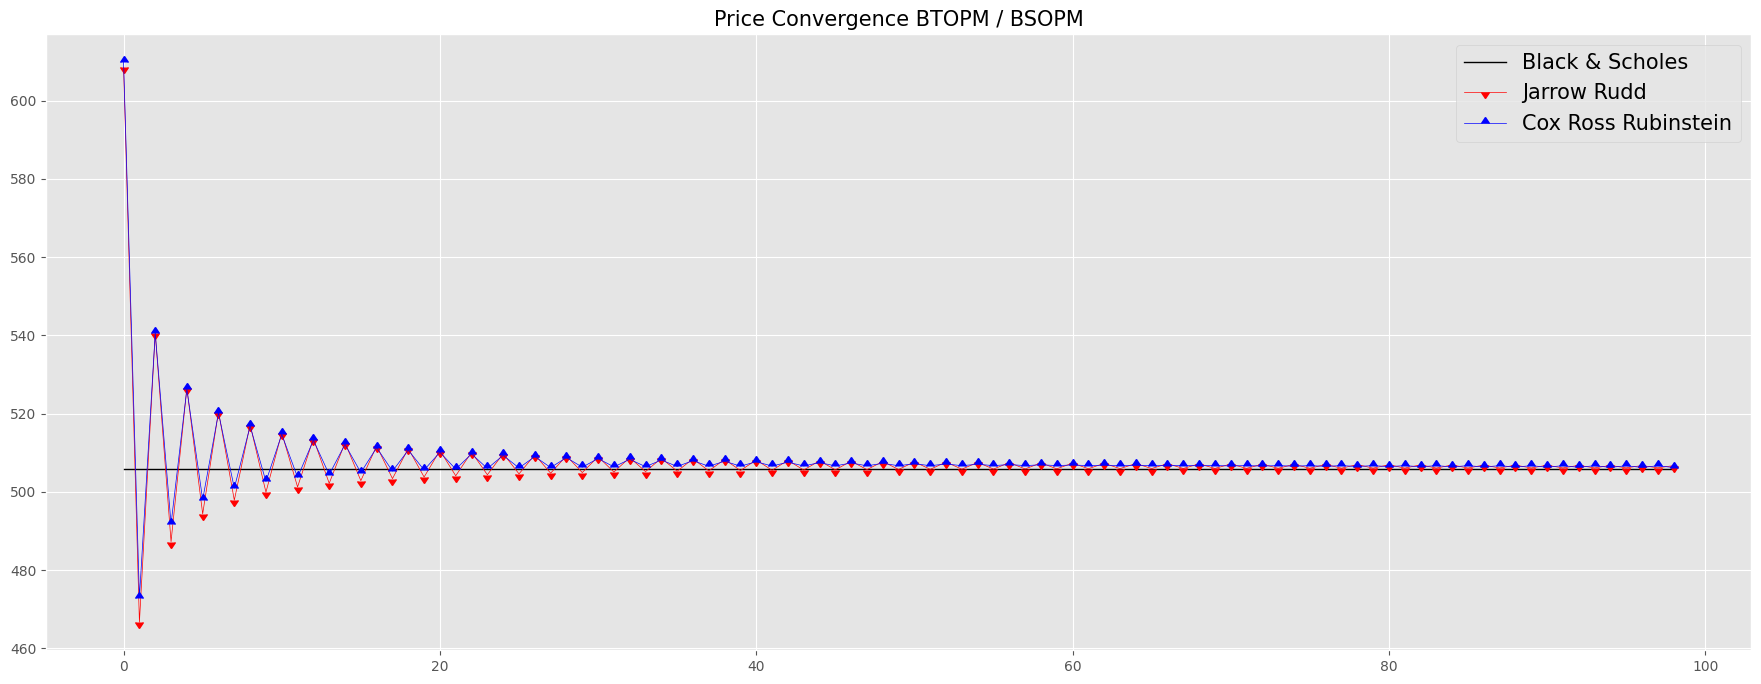

In [98]:
plt.figure(figsize=(22,8))

plt.style.use("ggplot")
plt.title("Price Convergence BTOPM / BSOPM",fontsize=15)
plt.plot(lista_bs,linewidth=1,color="black",label="Black & Scholes")
plt.plot(lista_jrr,linewidth=0.5,marker=11,label="Jarrow Rudd",color="red")
plt.plot(lista_crr,linewidth=0.5,marker=10,label="Cox Ross Rubinstein",color="blue")
plt.legend(fontsize=15)

# 9.0 Test with 20 Years

In [99]:
lista_crr=[]
lista_jrr=[]
lista_bs=[]
for a in range(1,100):
    lista_crr.append(CRR(S1,K1,annual_volatility,20,r1,a,"Call"))
    lista_jrr.append(JRR(S1,K1,annual_volatility,20,r1,a,"C"))
    lista_bs.append(N(black_scholes.subs(T,20).subs(S,S1).subs(K,K1).subs(v,annual_volatility).subs(r,r1).subs(q,0)))

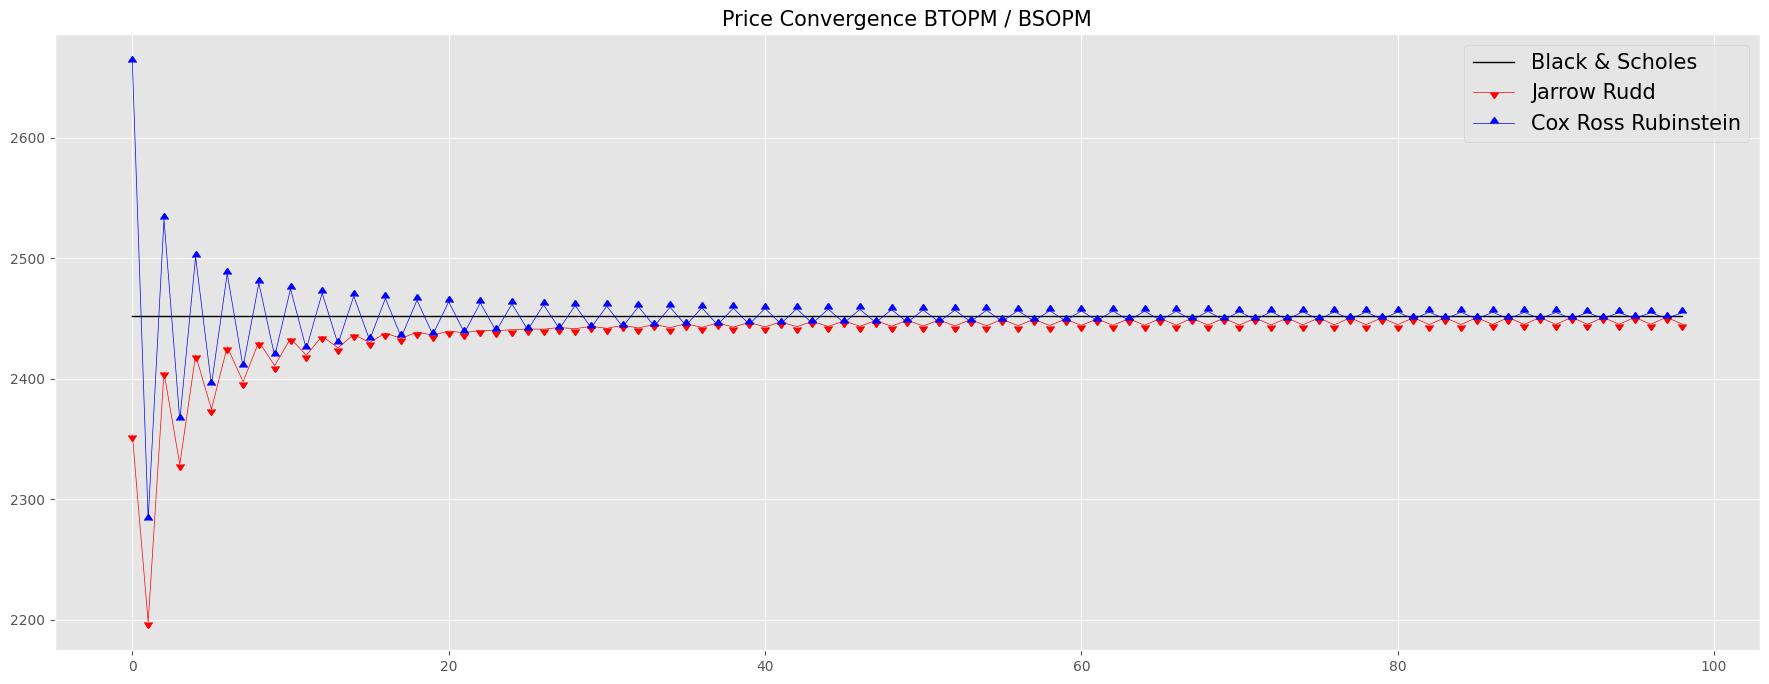

In [100]:
plt.figure(figsize=(22,8))

plt.style.use("ggplot")
plt.title("Price Convergence BTOPM / BSOPM",fontsize=15)
plt.plot(lista_bs,linewidth=1,color="black",label="Black & Scholes")
plt.plot(lista_jrr,linewidth=0.5,marker=11,label="Jarrow Rudd",color="red")
plt.plot(lista_crr,linewidth=0.5,marker=10,label="Cox Ross Rubinstein",color="blue")
plt.legend(fontsize=15)

# 10.0 Conclusion

The main errors in the BSOPM and in the BTOPM is that both of them assume the same risk free rate for all period of analysis, both of them assume the same historical volatility for all the subsequent times, and the stock price follows an Geometric Brownian Motion, which are not necessary true, so the convergence between the BTOPM  can show to us that in large Time/Steps the approximation from a BTOPM to a BSOPM can be very dangerous to the derivatives pricing

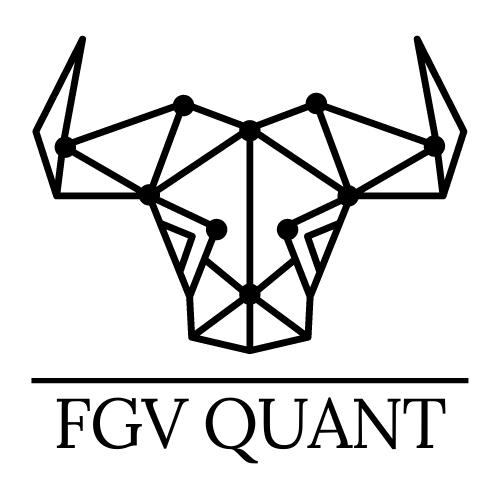